In [16]:
from __future__ import print_function

import os
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from scipy.special import logsumexp
from keras.layers.advanced_activations import LeakyReLU

# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Input, Lambda, Wrapper, merge, concatenate, Layer
from keras.engine import InputSpec
from keras.layers.core import Dense, Dropout, Activation, Lambda, Flatten
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras import initializers
import tensorflow as tf
from keras import regularizers
from keras.utils import plot_model
from keras.utils import model_to_dot

import random

import sys
sys.path.insert(0, '../code/')

seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)

%matplotlib inline
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

In [4]:
def load_data_file(data_file, num_features):
    
    data = np.load(data_file)
    
    if data.ndim == 1:
        data = data[None, :]
    
    x = data[:, :num_features]
    y = data[:, num_features:]
    
    return x, y

In [5]:
num_features = 13
x_data, y_data = load_data_file(data_file='../data/training.npy', num_features=num_features)
print(x_data.shape)
print(y_data.shape)

(79999, 13)
(79999, 5)


In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.125, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_train)
print(y_train)
print(x_test)
print(y_test)


(69999, 13)
(69999, 5)
(10000, 13)
(10000, 5)
[[1.42969119 1.42723809 1.45700746 ... 1.52030242 1.53700528 1.52595331]
 [1.47020541 1.47298698 1.47797513 ... 1.53386169 1.51145015 1.51952281]
 [1.48285264 1.47226227 1.52441086 ... 1.62959777 1.64439883 1.6440438 ]
 ...
 [1.61570794 1.62151468 1.61925598 ... 1.64087337 1.63933298 1.63658995]
 [1.41227214 1.42582642 1.45265958 ... 1.49828887 1.51577934 1.50500602]
 [1.52908202 1.51939086 1.52847161 ... 1.53891513 1.53116436 1.53396602]]
[[ 1.55448418e+03 -1.19571039e+01 -1.54221163e+00 -1.30000000e+01
  -4.49228038e+00]
 [ 1.29245750e+03 -8.36191902e+00 -1.17040395e+01 -1.54557173e+00
  -4.69567965e+00]
 [ 2.48145694e+03 -8.43972398e+00 -1.35519174e+00 -1.30000000e+01
  -4.17202308e+00]
 ...
 [ 2.28799316e+03 -1.38284960e+00 -4.75152001e+00 -1.30000000e+01
   7.60836252e-02]
 [ 1.53083506e+03 -5.42910194e+00 -1.90416890e+00 -1.30000000e+01
  -8.17397905e+00]
 [ 1.46297915e+03 -2.94685561e+00 -4.84560148e+00 -7.70012163e+00
   6.28969327e

In [7]:
#Normalise
x_train = (x_train - x_data.mean(0))/x_data.std(0)
x_test = (x_test - x_data.mean(0))/x_data.std(0)

y_train = (y_train - y_data.mean(0))/y_data.std(0)
y_test = (y_test - y_data.mean(0))/y_data.std(0)

In [8]:
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
ranges =  [[0, 3000], [-13, 0], [-13, 0], [-13, 0], [-13, 0]],
colors  = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"],

In [9]:
x_train = np.squeeze(x_train)
x_test = np.squeeze(x_test)
# x_data_te = np.squeeze(x_data_te)
print(x_train.shape)
print(y_train.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
y_train = sc.fit_transform(y_train)
y_test = sc.transform(y_test)

print(x_train)
print(y_train)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(69999, 13)
(69999, 5)
[[-0.2445163  -0.33817365 -0.14925207 ...  0.15903884  0.30631653
   0.26695959]
 [ 0.1602731   0.12095757  0.06511975 ...  0.29380459  0.05461225
   0.20361882]
 [ 0.28663526  0.11368447  0.53987512 ...  1.24532693  1.36408506
   1.43015843]
 ...
 [ 1.61403129  1.61156636  1.50956444 ...  1.35739533  1.31418916
   1.35673759]
 [-0.41855513 -0.35234095 -0.19370454 ... -0.05975418  0.09725248
   0.06062745]
 [ 0.74852644  0.58666219  0.58139198 ...  0.34403082  0.24878657
   0.34588533]]
[[-0.2113857  -1.45466145  1.31832054 -0.6743913   0.23479972]
 [-0.58966716 -0.49454824 -1.38720389  2.16775454  0.18780739]
 [ 1.12686206 -0.51532647  1.36811344 -0.6743913   0.30879034]
 ...
 [ 0.84756316  1.36924931  0.46386184 -0.6743913   1.2902513 ]
 [-0.24552734  0.28867614  1.22195164 -0.6743913  -0.61580121]
 [-0.34348925  0.9515732   0.43881322  0.64064835  1.28720472]]
(69999, 13)
(69999, 5)
(10000, 13)
(10000, 5)


In [10]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_train.shape)
print(x_test.shape)


(69999, 13, 1)
(10000, 13, 1)


In [11]:

        
# #         tf.keras.Input(shape=(69999,13), batch_size = 100),
# #         tf.keras.layers.Dense(128, activation = 'linear'),
#         # Start with the first convolution
#         tf.keras.layers.Conv1D(16, 3, activation='relu', batch_input_shape=(None,13,1)),
#         tf.keras.layers.MaxPooling1D(2, 2),
# # The second convolution
#         tf.keras.layers.Conv1D(32, 3, activation='relu'),
#         tf.keras.layers.MaxPooling1D(2,2),
# # The third convolution
# #         tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
# #         tf.keras.layers.MaxPooling2D(2,2),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(512, activation = 'relu'),
#         tf.keras.layers.Dense(256, activation = 'linear'),
# #         tf.keras.layers.Dropout(0.8),
#         tf.keras.layers.Dense(256, activation = 'relu'),
# #         tf.keras.layers.Dropout(0.8),
    

# model.add(Convolution1D(16, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
# model.add(MaxPooling1D(pool_size=3))
# model.add(Convolution1D(16, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3))
# model.add(Convolution1D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3))
# model.add(Convolution1D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3))
# model.add(Convolution1D(128, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(Convolution1D(128, kernel_size=2, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Convolution1D(128, kernel_size=2, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))

#         tf.keras.layers.Dense(5, activation = tf.keras.layers.LeakyReLU(alpha=0.3)
#tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9)

model = Sequential()
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(tf.keras.layers.Dense(5, activation = 'linear'))
# from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = 'adam' ,loss = 'mean_squared_error')

model.build(input_shape = (None, 13))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1

In [12]:
history = model.fit(x_train, y_train, verbose=1, batch_size=1000, epochs = 1000)

Epoch 1/1000
70/70 [==============================] - 5s 70ms/step - loss: 0.5653
Epoch 2/1000
70/70 [==============================] - 6s 80ms/step - loss: 0.3758
Epoch 3/1000
70/70 [==============================] - 5s 70ms/step - loss: 0.3557
Epoch 4/1000
70/70 [==============================] - 6s 83ms/step - loss: 0.3467: 0s - los
Epoch 5/1000
70/70 [==============================] - 6s 86ms/step - loss: 0.3423
Epoch 6/1000
70/70 [==============================] - 8s 113ms/step - loss: 0.3385
Epoch 7/1000
70/70 [==============================] - 7s 107ms/step - loss: 0.3352
Epoch 8/1000
70/70 [==============================] - 5s 69ms/step - loss: 0.3334
Epoch 9/1000
70/70 [==============================] - 5s 66ms/step - loss: 0.3311
Epoch 10/1000
70/70 [==============================] - 5s 73ms/step - loss: 0.3288
Epoch 11/1000
70/70 [==============================] - 6s 86ms/step - loss: 0.3276
Epoch 12/1000
70/70 [==============================] - 7s 105ms/step - loss: 0.3277


70/70 [==============================] - 4s 63ms/step - loss: 0.0792
Epoch 197/1000
70/70 [==============================] - 5s 75ms/step - loss: 0.0819
Epoch 198/1000
70/70 [==============================] - 5s 74ms/step - loss: 0.0780
Epoch 199/1000
70/70 [==============================] - 5s 76ms/step - loss: 0.0784
Epoch 200/1000
70/70 [==============================] - 5s 70ms/step - loss: 0.0770
Epoch 201/1000
70/70 [==============================] - 4s 61ms/step - loss: 0.0739
Epoch 202/1000
70/70 [==============================] - 5s 74ms/step - loss: 0.0744
Epoch 203/1000
70/70 [==============================] - 5s 77ms/step - loss: 0.0730
Epoch 204/1000
70/70 [==============================] - 5s 74ms/step - loss: 0.0721
Epoch 205/1000
70/70 [==============================] - 4s 59ms/step - loss: 0.0737
Epoch 206/1000
70/70 [==============================] - 4s 62ms/step - loss: 0.0721
Epoch 207/1000
70/70 [==============================] - 4s 55ms/step - loss: 0.0712
Epoch 2

70/70 [==============================] - 4s 60ms/step - loss: 0.0248
Epoch 391/1000
70/70 [==============================] - 6s 81ms/step - loss: 0.0253
Epoch 392/1000
70/70 [==============================] - 7s 94ms/step - loss: 0.0311
Epoch 393/1000
70/70 [==============================] - 5s 66ms/step - loss: 0.0305
Epoch 394/1000
70/70 [==============================] - 5s 69ms/step - loss: 0.0270
Epoch 395/1000
70/70 [==============================] - 6s 81ms/step - loss: 0.0270
Epoch 396/1000
70/70 [==============================] - 5s 65ms/step - loss: 0.0238
Epoch 397/1000
70/70 [==============================] - 5s 74ms/step - loss: 0.0225
Epoch 398/1000
70/70 [==============================] - 6s 82ms/step - loss: 0.0215
Epoch 399/1000
70/70 [==============================] - 5s 77ms/step - loss: 0.0200
Epoch 400/1000
70/70 [==============================] - 5s 67ms/step - loss: 0.0210
Epoch 401/1000
70/70 [==============================] - 6s 81ms/step - loss: 0.0221
Epoch 4

70/70 [==============================] - 4s 52ms/step - loss: 0.0138
Epoch 585/1000
70/70 [==============================] - 3s 46ms/step - loss: 0.0165
Epoch 586/1000
70/70 [==============================] - 4s 51ms/step - loss: 0.0185
Epoch 587/1000
70/70 [==============================] - 3s 47ms/step - loss: 0.0211
Epoch 588/1000
70/70 [==============================] - 3s 47ms/step - loss: 0.0187
Epoch 589/1000
70/70 [==============================] - 3s 47ms/step - loss: 0.0206
Epoch 590/1000
70/70 [==============================] - 3s 48ms/step - loss: 0.0215
Epoch 591/1000
70/70 [==============================] - 3s 47ms/step - loss: 0.0197
Epoch 592/1000
70/70 [==============================] - 4s 52ms/step - loss: 0.0162
Epoch 593/1000
70/70 [==============================] - 3s 47ms/step - loss: 0.0145
Epoch 594/1000
70/70 [==============================] - 3s 49ms/step - loss: 0.0144
Epoch 595/1000
70/70 [==============================] - 4s 52ms/step - loss: 0.0149
Epoch 5

70/70 [==============================] - 3s 49ms/step - loss: 0.0079
Epoch 779/1000
70/70 [==============================] - 3s 49ms/step - loss: 0.0073
Epoch 780/1000
70/70 [==============================] - 3s 49ms/step - loss: 0.0069
Epoch 781/1000
70/70 [==============================] - 5s 67ms/step - loss: 0.0070
Epoch 782/1000
70/70 [==============================] - 3s 46ms/step - loss: 0.0077
Epoch 783/1000
70/70 [==============================] - 3s 45ms/step - loss: 0.0081
Epoch 784/1000
70/70 [==============================] - 3s 45ms/step - loss: 0.0091
Epoch 785/1000
70/70 [==============================] - 3s 45ms/step - loss: 0.0109
Epoch 786/1000
70/70 [==============================] - 3s 45ms/step - loss: 0.0160
Epoch 787/1000
70/70 [==============================] - 3s 45ms/step - loss: 0.0267
Epoch 788/1000
70/70 [==============================] - 3s 49ms/step - loss: 0.0302
Epoch 789/1000
70/70 [==============================] - 3s 48ms/step - loss: 0.0254
Epoch 7

70/70 [==============================] - 4s 57ms/step - loss: 0.0050
Epoch 973/1000
70/70 [==============================] - 4s 54ms/step - loss: 0.0051
Epoch 974/1000
70/70 [==============================] - 4s 51ms/step - loss: 0.0055
Epoch 975/1000
70/70 [==============================] - 3s 49ms/step - loss: 0.0065
Epoch 976/1000
70/70 [==============================] - 4s 56ms/step - loss: 0.0075
Epoch 977/1000
70/70 [==============================] - 3s 49ms/step - loss: 0.0095
Epoch 978/1000
70/70 [==============================] - 4s 51ms/step - loss: 0.0111
Epoch 979/1000
70/70 [==============================] - 3s 48ms/step - loss: 0.0140
Epoch 980/1000
70/70 [==============================] - 3s 49ms/step - loss: 0.0223
Epoch 981/1000
70/70 [==============================] - 4s 53ms/step - loss: 0.0261
Epoch 982/1000
70/70 [==============================] - 4s 51ms/step - loss: 0.0193
Epoch 983/1000
70/70 [==============================] - 3s 49ms/step - loss: 0.0123
Epoch 9

313/313 [==============================] - 1s 3ms/step - loss: 0.5329


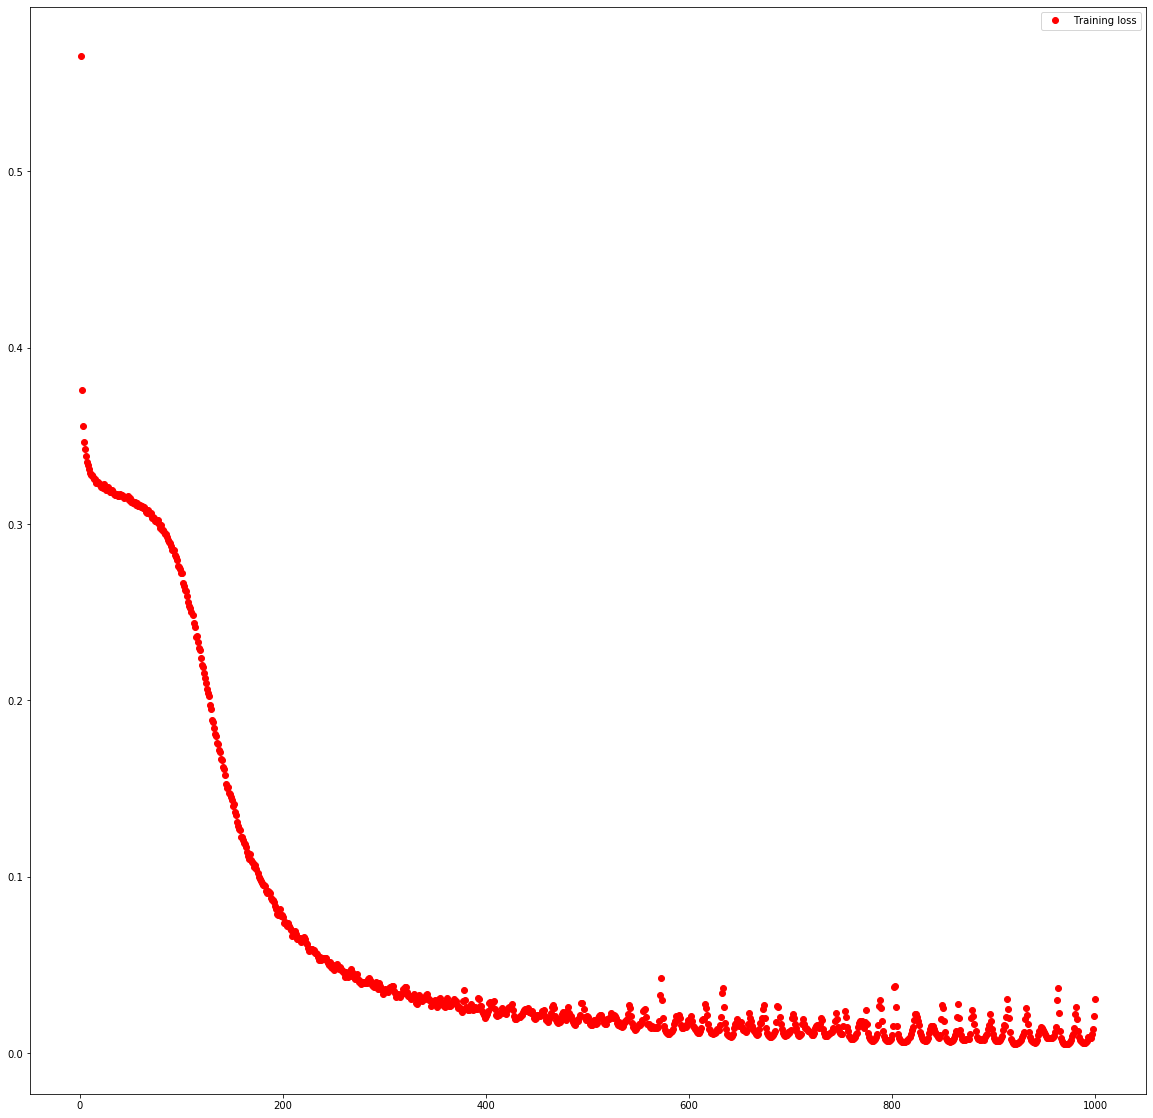

In [67]:
test_loss = model.evaluate(x_test, y_test)
loss = history.history['loss']
epochs = range(1, len(loss)+1)
plt.figure(figsize=(20,20))
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.savefig('LossCurveTraining2.png')
plt.legend()
plt.show()


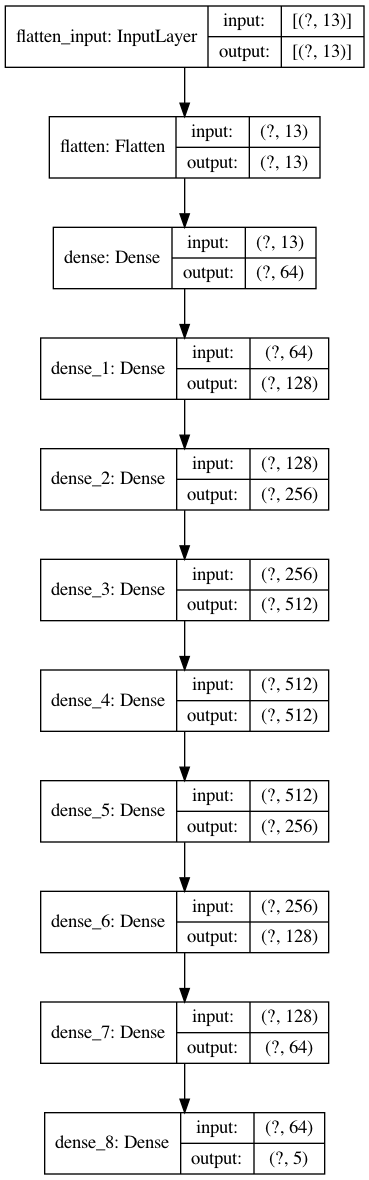

In [22]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [24]:
y_pred = model.predict(x_test)
print(y_pred.shape)
print(y_test.shape)
print(y_pred)
print(y_test)

(10000, 5)
(10000, 5)
[[-0.00166978 -0.00873767 -0.00874555  0.01324755 -0.00756202]
 [-0.00063605 -0.01512164 -0.01208506  0.02664722 -0.0224551 ]
 [ 0.00439475 -0.01099869 -0.00429098  0.00487273 -0.01032936]
 ...
 [ 0.00467641 -0.04313541 -0.02625758  0.09213802 -0.07106975]
 [-0.00452538 -0.01730058 -0.02137301  0.03170604 -0.02760338]
 [ 0.00226339 -0.01228038 -0.00773964  0.02151745 -0.01969409]]
[[ 0.02645042  0.63024774  0.89497631 -0.6743913  -0.78725769]
 [-1.49854235  0.09304495  0.49033705  1.68367567  0.14208416]
 [ 0.34959624 -1.63868495  0.25047298 -0.6743913   0.72760226]
 ...
 [ 1.3965597  -0.99208046  1.56025408 -0.6743913   0.14914516]
 [ 1.49190436 -0.11696037 -0.94976326 -0.6743913  -0.14257609]
 [-1.0484301   0.07954416  0.77791907  0.06213806  0.65147749]]


In [25]:
from sklearn import metrics
import numpy as np

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
print("Final score (RMSE): {}".format(score))
print(names)

Final score (RMSE): 1.0047375292504117
['T (K)', 'H2O', 'HCN', 'NH3', 'kappa0']


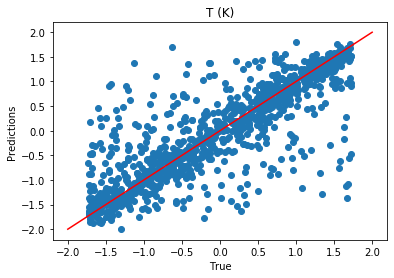

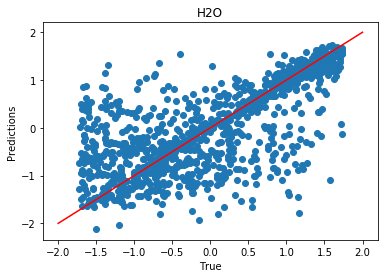

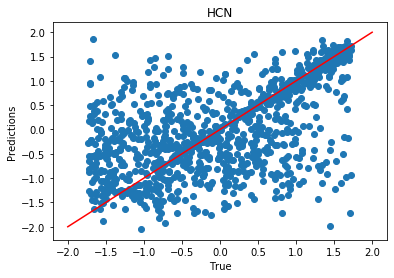

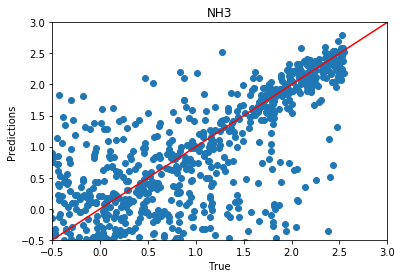

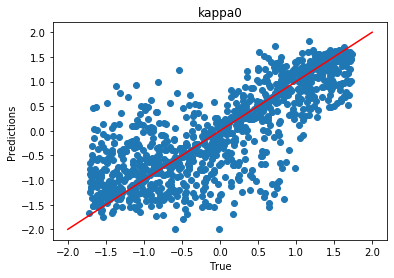

In [65]:
yyy = [-2,2]

#T(K)
plt.title(names[0])
plt.ylabel('Predictions')
plt.xlabel('True')
plt.scatter(y_test[:1000 , 0], y_pred[:1000, 0])
plt.plot(yyy,yyy,'r')
plt.savefig(names[0]+'pred_vs_true.png')
plt.show()

#H20
plt.title(names[1])
plt.ylabel('Predictions')
plt.xlabel('True')
plt.scatter(y_test[:1000 , 1], y_pred[:1000, 1])
plt.plot(yyy,yyy,'r')
plt.savefig(names[1]+'pred_vs_true.png')
plt.show()

#HCN
plt.title(names[2])
plt.ylabel('Predictions')
plt.xlabel('True')
plt.scatter(y_test[:1000 , 2], y_pred[:1000, 2])
plt.plot(yyy,yyy,'r')
plt.savefig(names[2]+'pred_vs_true.png')
plt.show()

#NH3
xxx = [-3,3]
plt.title(names[3])
plt.ylabel('Predictions')
plt.xlabel('True')
plt.scatter(y_test[:2000 , 3], y_pred[:2000, 3])
# plt.yticks(np.arange(-1, 2, 0.5))
# plt.xticks(np.arange(-1, 2, 0.5))
plt.ylim(-0.5,3)
plt.xlim(-0.5,3)
plt.plot(xxx,xxx,'r')
plt.savefig(names[3]+'pred_vs_true.png')
plt.show()

#Kappa (Cloud opacity)
plt.title(names[4])
plt.ylabel('Predictions')
plt.xlabel('True')
plt.scatter(y_test[:1000 , 4], y_pred[:1000, 4])
plt.plot(yyy,yyy,'r')
plt.savefig(names[4]+'pred_vs_true.png')
plt.show()

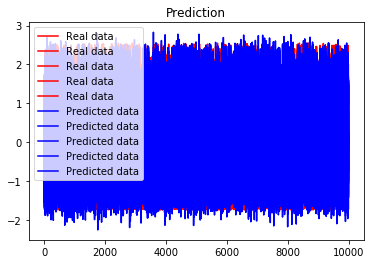

[[ 0.13567758  0.5390362   0.7409521  -0.6756515  -1.3455058 ]
 [-1.2297214   0.14823206  0.07149965  1.4362822   0.27712813]
 [-1.0750571   0.5001657   0.2551354   1.1361758   1.7144399 ]
 ...
 [ 1.2346334  -0.4706274   1.5959688  -0.6724423  -1.4106469 ]
 [ 1.1504332  -0.02563194 -0.23094714 -0.7012229  -0.1750975 ]
 [ 0.9789289  -0.6490955   0.17574216 -0.7207364   0.358927  ]]
[[ 0.02645042  0.63024774  0.89497631 -0.6743913  -0.78725769]
 [-1.49854235  0.09304495  0.49033705  1.68367567  0.14208416]
 [ 0.34959624 -1.63868495  0.25047298 -0.6743913   0.72760226]
 ...
 [ 1.3965597  -0.99208046  1.56025408 -0.6743913   0.14914516]
 [ 1.49190436 -0.11696037 -0.94976326 -0.6743913  -0.14257609]
 [-1.0484301   0.07954416  0.77791907  0.06213806  0.65147749]]


In [24]:
y_pred = y_pred
y_test = y_test
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()
print(y_pred)
print(y_test)

In [ ]:
def posterior_matrix(estimations, y, names, ranges, colors, soft_colors=None):
    
    cmaps = [LinearSegmentedColormap.from_list("MyReds", [(1, 1, 1), c], N=256)
             for c in colors]
    
    ranges = np.array(ranges)
    
    if soft_colors is None:
        soft_colors = colors
    
    num_dims = estimations.shape[1]
    
    fig, axes = plt.subplots(nrows=num_dims, ncols=num_dims,
                             figsize=(2 * num_dims, 2 * num_dims))
    fig.subplots_adjust(left=0.07, right=1-0.05,
                        bottom=0.07, top=1-0.05,
                        hspace=0.05, wspace=0.05)
    
    for ax, dims in zip(axes.flat, product(range(num_dims), range(num_dims))):
        dims = list(dims[::-1])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_visible(False)
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_visible(True)
            if names is not None:
                ax.set_ylabel(names[dims[1]], fontsize=18)
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_visible(True)
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_visible(True)
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.xaxis.set_visible(True)
            if names is not None:
                ax.set_xlabel(names[dims[0]], fontsize=18)
        if ax.is_first_col() and ax.is_first_row():
            ax.yaxis.set_visible(False)
            ax.set_ylabel("")
        if ax.is_last_col() and ax.is_last_row():
            ax.yaxis.set_visible(False)
        
        if dims[0] < dims[1]:
            # locations, kd_probs, *_ = _kernel_density_joint(estimations[:, dims], ranges[dims])
            # ax.contour(locations[0], locations[1],
            #            kd_probs,
            #            colors=colors[dims[0]],
            #            linewidths=0.5
            #            # 'copper', # 'hot', 'magma' ('copper' with white background)
            #           )
            histogram, grid_x, grid_y = _histogram(estimations[:, dims], ranges[dims])
            ax.pcolormesh(grid_x, grid_y, histogram, cmap=cmaps[dims[0]])
            
            expected = np.median(estimations[:, dims], axis=0)
            ax.plot([expected[0], expected[0]], [ranges[dims[1]][0], ranges[dims[1]][1]], '-', linewidth=1, color='#222222')
            ax.plot([ranges[dims[0]][0], ranges[dims[0]][1]], [expected[1], expected[1]], '-', linewidth=1, color='#222222')
            ax.plot(expected[0], expected[1], '.', color='#222222')
            ax.axis('normal')
            if y is not None:
                real = y[dims]
                ax.plot(real[0], real[1], '*', markersize=10, color='#FF0000')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        elif dims[0] > dims[1]:
            ax.plot(estimations[:, dims[0]], estimations[:, dims[1]], '.', color=soft_colors[dims[1]])
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        else:
            histogram, bins = _histogram(estimations[:, dims[:1]], ranges=ranges[dims[:1]])
            ax.bar(bins[:-1], histogram, color=soft_colors[dims[0]], width=bins[1]-bins[0])
            
            kd_probs = histogram
            expected = np.median(estimations[:, dims[0]])
            ax.plot([expected, expected], [0, 1.1 * kd_probs.max()], '-', linewidth=1, color='#222222')
            
            if y is not None:
                real = y[dims[0]]
                ax.plot([real, real], [0, kd_probs.max()], 'r-')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     0, 1.1 * kd_probs.max()])
    
    # fig.tight_layout(pad=0)
    return fig